# Input Files

In [3]:
import pandas as pd
import json
from glob import glob

def safe_json_loads(s):
    try:
        return json.loads(s.replace("'", '"'))  # Attempt to replace single quotes with double quotes
    except json.JSONDecodeError:
        print(f"Failed to parse JSON: {s}")
        return None  # You can decide to return an empty dict or similar depending on how you want to handle errors

def preprocess_data(file_path, type_of_data):
    # Load data
    data = pd.read_csv(file_path, delimiter=';')
    
    # Parse the Volumes column which is in json string format with error handling
    data['Volumes'] = data['Volumes'].apply(safe_json_loads)
    
    # Filter out rows where Volumes could not be parsed
    data = data[data['Volumes'].notnull()]

    # Expand the Volumes column into a DataFrame
    expanded_rows = []
    for index, row in data.iterrows():
        for volume in row['Volumes']:
            key = pd.to_datetime(volume['Key'], format='%Y-%m-%d:%H')
            expanded_rows.append({
                'Id': row['Id'],
                'Start': pd.to_datetime(row['Start']),
                'End': pd.to_datetime(row['End']),
                key: volume['Value']
            })
    
    # Create a DataFrame from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)
    expanded_df = expanded_df.groupby(['Id', 'Start', 'End']).sum().reset_index()
    expanded_df.set_index('Id', inplace=True)
    
    # Save the processed data based on type (consumption or production)
    expanded_df.to_csv(f'{type_of_data}_processed.csv')

# Directory containing your CSV files
directory_path = 'dataset'
consumption_files = glob(f'{directory_path}/consumption-*.csv')
production_files = glob(f'{directory_path}/production-*.csv')

# Process all files
for file in consumption_files:
    preprocess_data(file, 'consumption')
for file in production_files:
    preprocess_data(file, 'production')


KeyboardInterrupt: 

In [2]:
run_folder = '/samoa/data/smrserraoseabr/subsidence-da/model/runs/'
run_name = 'geothermal_subsidence_brugge_FINAL'



refence_case = os.path.join(run_folder,run_name, 'reference', 'reference.nc')

DPrior = np.array(pd.read_pickle(os.path.join(run_folder,run_name,'it0/D_0.pkl')))
DPost = np.array(pd.read_pickle(os.path.join(run_folder,run_name,'it3/D_3.pkl')))

MObj =[]
for i in range(4):
    MObj.append(np.array(pd.read_pickle(os.path.join(run_folder,run_name,f'it{i}/MObj_{i}.pkl'))))
MObj = np.array(MObj)


#read dObs.npy and dsts.npy and MGridPrior.pkl and /it3/MGridPost.pkl and MReference.pkl
MGridPrior = np.array(pd.read_pickle(os.path.join(run_folder,run_name,'MGridPrior.pkl')))
MGridPost = np.array(pd.read_pickle(os.path.join(run_folder,run_name,'it3/MGridPost.pkl')))
MReference = np.array(pd.read_pickle(os.path.join(run_folder,run_name,'MReference.pkl')))
# read dObs.npy (it is not a pkl)
dObs = np.array(np.load(os.path.join(run_folder,run_name,'dObs.npy')))
dstd = np.array(np.load(os.path.join(run_folder,run_name,'dstd.npy')))



In [3]:
#print all the shapes
print(f'DPrior: {DPrior.shape}')
print(f'DPost: {DPost.shape}')
print(f'MObj: {MObj.shape}')
print(f'MGridPrior: {MGridPrior.shape}')
print(f'MGridPost: {MGridPost.shape}')
print(f'dObs: {dObs.shape}')
print(f'dstd: {dstd.shape}')




DPrior: (139, 100)
DPost: (139, 100)
MObj: (4, 4, 100)
MGridPrior: (6672, 100)
MGridPost: (6672, 100)
dObs: (139,)
dstd: (139,)


In [4]:
#for post processing the permeability results we need to lead a mask
#read the referent case /samoa/data/smrserraoseabr/subsidence-da/model/runs/geothermal_subsidence_brugge_FINAL/reference/reference.nc and get the cells where pressure is zero in th last time. This is the mask./ Remember to load xarray
ref = xr.open_dataset(refence_case)
mask = ref['pressure'][-1,:,:].values != 0

In [5]:

Ni = len(ref.X)
Nj = len(ref.Y)
mask.shape

(1, 48, 139)

In [6]:
# Function to reshape and mask MGrid data for a single realization
def prepare_mgrid_data(MGrid, mask, X, Y):
    reshaped = MGrid.reshape(Y, X)
    masked = reshaped * mask
    return masked

# Prepare and store all realizations for Prior and Post in lists
Prior_realizations = [prepare_mgrid_data(MGridPrior[:,i], mask, Ni, Nj) for i in range(MGridPrior.shape[1])]
Post_realizations = [prepare_mgrid_data(MGridPost[:,i], mask, Ni, Nj) for i in range(MGridPost.shape[1])]
Reference_realization = prepare_mgrid_data(MReference, mask, Ni, Nj)

/tmp/ipykernel_848521/2822803495.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


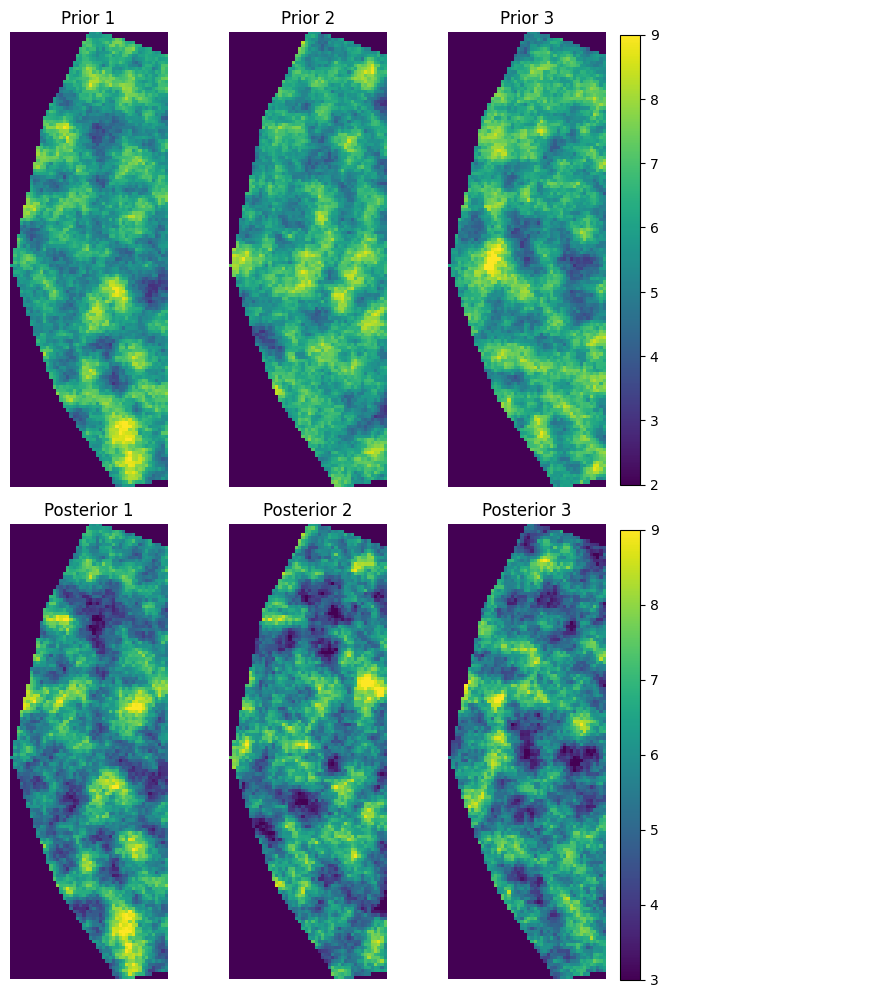

In [12]:


fig, axes = plt.subplots(2, 4, figsize=(10, 10))  # 2 rows, 4 columns

# Loop through the first three columns for each row to plot realizations
for i in range(3):

    im = axes[0, i].imshow(Prior_realizations[i][0].T, cmap='viridis' , vmin=2, vmax=9)
    axes[0, i].set_title(f'Prior {i+1}')
    axes[0, i].axis('off')

    im_post = axes[1, i].imshow(Post_realizations[i][0].T, cmap='viridis' , vmin=3, vmax=9)
    axes[1, i].set_title(f'Posterior {i+1}')
    axes[1, i].axis('off')

# Colorbars
cbar_ax = fig.add_axes([0.66, 0.51, 0.02, 0.45])  # Position for upper row colorbar
fig.colorbar(im, cax=cbar_ax)
cbar_ax_post = fig.add_axes([0.66, 0.015, 0.02, 0.45])  # Position for lower row colorbar
fig.colorbar(im_post, cax=cbar_ax_post)

# Removing the unused last column in each row
axes[0, 3].axis('off')
axes[1, 3].axis('off')

plt.tight_layout()
plt.subplots_adjust(right=0.9)  # Adjusting space to fit colorbars
plt.show()


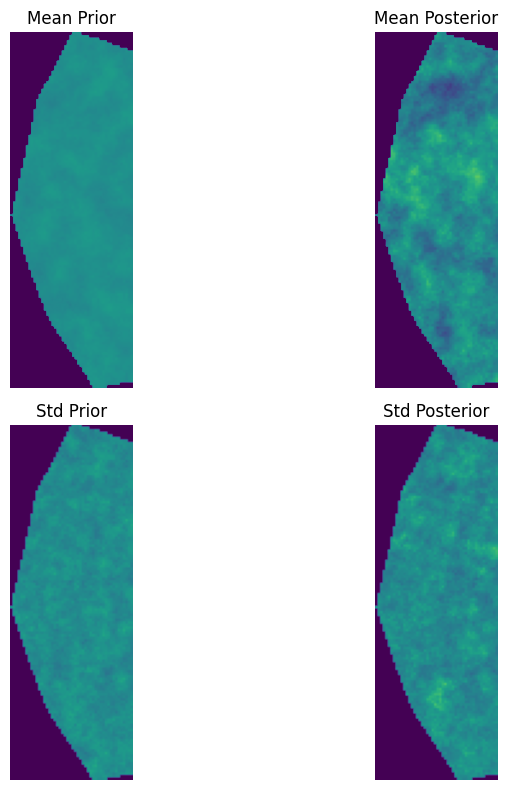

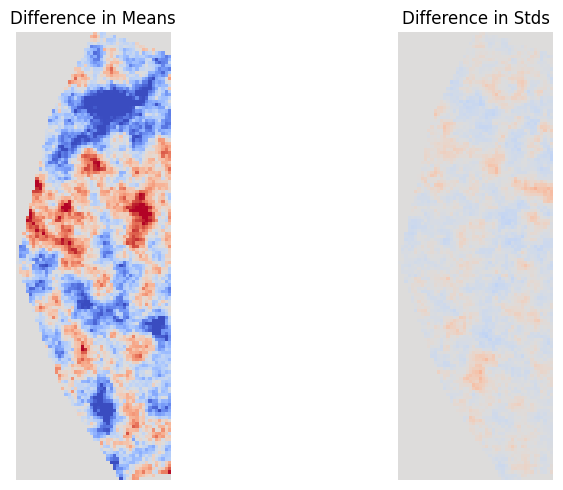

In [8]:
# Calculate mean and standard deviation for Prior and Posterior realizations
mean_prior = np.mean(np.array(Prior_realizations), axis=0)
std_prior = np.std(np.array(Prior_realizations), axis=0)

mean_post = np.mean(np.array(Post_realizations), axis=0)
std_post = np.std(np.array(Post_realizations), axis=0)

# Set up the plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) # 2 rows (mean, std), 2 columns (Prior, Post)

# Plot Mean Images
axes[0, 0].imshow(mean_prior.T, cmap='viridis', vmin=3, vmax=9)
axes[0, 0].set_title('Mean Prior')
axes[0, 0].axis('off')

axes[0, 1].imshow(mean_post.T, cmap='viridis', vmin=3, vmax=9)
axes[0, 1].set_title('Mean Posterior')
axes[0, 1].axis('off')

# Plot Std Images
axes[1, 0].imshow(std_prior.T, cmap='viridis', vmin=0, vmax=2)
axes[1, 0].set_title('Std Prior')
axes[1, 0].axis('off')

axes[1, 1].imshow(std_post.T, cmap='viridis', vmin=0, vmax=2)
axes[1, 1].set_title('Std Posterior')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Optional: Highlight changes by computing the differences
diff_mean = mean_post - mean_prior
diff_std = std_post - std_prior

# Visualize the differences if needed
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(diff_mean.T, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Difference in Means')
axes[0].axis('off')

axes[1].imshow(diff_std.T, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Difference in Stds')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
prior_realizations = DPrior
posterior_realizations = DPost
perturbed_dObs = dObs + np.random.normal(0, dstd, size=dObs.shape)
plt.style.use(['science','no-latex'])
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Prior realizations without labels
for realization_prior in prior_realizations.T:
    ax.plot(realization_prior, color='gray', alpha=0.8, linewidth=2.0)

# Plot Posterior realizations without labels
for realization_posterior in posterior_realizations.T:
    ax.plot(realization_posterior, color='blue', alpha=0.3)

# Assuming that x_values is your array of x-values. If you don't have one, you could use np.arange(len(dObs)).
x_values = np.arange(len(dObs))

#Ce_aggregated = np.sum(Ce, axis=1)  # or some other operation to make it 1D
#ax.errorbar(x_values, dObs, yerr=dstd, fmt='o', color='r')
plt.plot(x_values, perturbed_dObs, 'o', color='r', linestyle='None')
# Manually specify the labels for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='gray', lw=2, label='Prior'),
                Line2D([0], [0], color='blue', lw=2, label='Posterior'),
                Line2D([0], [0], marker='o', color='r', lw=0, label='Observed Data')]

ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

#ax.set_title(f'History Matching', fontsize=15)
ax.set_xlabel('I-index', fontsize=15)

y_label = 'Displacements (mm)'

ax.set_ylabel(y_label, fontsize=15)

plt.tight_layout()


OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [10]:
pip install SciencePlots

Note: you may need to restart the kernel to use updated packages.
